# Evaluating the performance of 10 Yr - 2Yr US Treasury Yield Curve spread trade. 

We are using data here derived from the US Federal Reserve website: 

https://www.federalreserve.gov/data/nominal-yield-curve.htm

### Yield curve trading

A yield curve spread is the yield differential between two different maturities of a bond
issuer i.e. 10 yr U.S. Treasury yield - 2 yr U.S. Treasury yield. The later maturity leg of the
trade is referred to as the back leg and the trade leg maturing earlier is called the front leg.
Two primary yield curve spread strategies are the “flattener” and the “steepener.” The risk
measure for yield curve spread trades is DV01 (dollar value of a basis point), As the back
leg DV01 is greater than the front leg DV01, one must calculate a hedge ratio to result in a
DV01 neutral position.

In [7]:
import os
os.chdir(r"C:\Users\anany\Documents\MFE Q1\Investments\Code")
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import scipy.stats as ss
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt

We are creating a Function to define the NSS model clearly. We use this NSS Function on the data taken from US Fed Reserve site. 

We start by reformatting the data.

In [2]:
# Nelson-Siegel-Svensson Function for ZCB yields
def nssyld(b0, b1, b2, b3, t1, t2, m):
    mt1 = m/t1
    mt2 = m/t2
    expmt1 = np.exp(-mt1)
    expmt2 = np.exp(-mt2)
    c1 = (1-expmt1)/mt1
    c2 = c1 - expmt1
    c3 = (1-expmt2)/mt2 - expmt2
    return(np.exp((b0 + b1 * c1 + b2 * c2 + b3 * c3)/100)-1) #make annual compounding

yc = pd.read_csv("gsw_yields_2022.csv")
yc = yc.rename(columns={"Date": "DATE"})
yc['DATE'] = pd.to_datetime(yc['DATE'], format = '%m/%d/%Y')
yc = yc.dropna( how='any', subset=["BETA0", "BETA1", "BETA2", "BETA3", "TAU1","TAU2"])a

A roll-down return is a strategy for maximizing a bond's overall yield by exploiting the yield curve. It is dependant on the fact that the value of a bond converges to par as its maturity date approaches. 

A roll-down return is a bond trading method for selling a bond as it is getting close to its maturity date when the initial higher interest rate of the long-term bond has declined.

In [3]:
begindate = "1983-12-30"
enddate = "2022-09-20"
filt = (yc['DATE'] >= begindate) & (yc['DATE'] <= enddate)
yc = yc.loc[filt]

yc = yc.sort_values(by='DATE')
yc['date'] = yc['DATE']
#only keep required variables
yc = yc[["date", "DATE", "BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]]
#resample data (at weekly intervals)
yc = yc.set_index('DATE')
yc = yc.resample('W-Fri').last()
yc['date']= yc.index.to_series()
# Calculate time difference in days to next and past periods
yc['dayslast'] = yc['date'].diff()
yc['dayslast1'] = yc['dayslast'].dt.days #convert time difference into days in integer form
yc['dayslast'] = yc['dayslast1'] #rename back into days last
yc['daysnext'] = yc['dayslast1'].shift(-1)
#compute date of maturity
yc['noleap_date'] = yc['date'].apply(lambda x:x if x.month != 2 and x.date != 29 else pd.datetime(x.year, x.month, 28))

#compute ytm as well as rolldown ytm
yc['m2'] = yc.apply(lambda x: (x['noleap_date'] + pd.offsets.DateOffset(years=2) -x['date']).days/365, axis =1)
yc['m10'] = yc.apply(lambda x:(x['noleap_date'] + pd.offsets.DateOffset(years=10) -x['date']).days/365, axis =1)
yc['m2rd'] = yc.apply(lambda x: x['m2'] - x['dayslast']/365, axis=1)
yc['m10rd'] = yc.apply(lambda x:x['m10'] - x['dayslast']/365, axis=1)

#designate the prefix 'L' to imply a lagged variable
yc['Lm2'] = yc['m2'].shift()
yc['Lm10'] = yc['m10'].shift()
# calculate yields

yc['y2'] = yc.apply(lambda row: nssyld(row['BETA0'], row['BETA1'],row['BETA2'], row['BETA3'], row['TAU1'], row['TAU2'], row['m2']), axis=1)
yc['y2rd'] = yc.apply(lambda row: nssyld(row['BETA0'], row['BETA1'],row['BETA2'], row['BETA3'], row['TAU1'], row['TAU2'], row['m2rd']), axis=1)
yc['y10'] = yc.apply(lambda row: nssyld(row['BETA0'], row['BETA1'],row['BETA2'], row['BETA3'], row['TAU1'], row['TAU2'], row['m10']), axis=1)
yc['y10rd'] = yc.apply(lambda row: nssyld(row['BETA0'], row['BETA1'],row['BETA2'], row['BETA3'], row['TAU1'], row['TAU2'], row['m10rd']), axis=1)
yc['Ly2'] = yc['y2'].shift()
yc['Ly10'] = yc['y10'].shift()

# weekly yield
yc['y7d'] = yc.apply(lambda row: nssyld(row['BETA0'], row['BETA1'],row['BETA2'], row['BETA3'], row['TAU1'], row['TAU2'], row['daysnext']/365),axis=1)
yc['Ly7d'] = yc['y7d'].shift()

#calculate prices
def y2z(r,m):
    return 1/(1+r)**m

yc['p2'] = yc.apply(lambda row: y2z(row['y2'],row['m2']), axis =1)
yc['p2rd'] = yc.apply(lambda row: y2z(row['y2rd'],row['m2rd']), axis =1)
yc['Lp2'] = yc['p2'].shift()
yc['p10'] = yc.apply(lambda row: y2z(row['y10'],row['m10']), axis =1)
yc['p10rd'] = yc.apply(lambda row: y2z(row['y10rd'],row['m10rd']), axis =1)
yc['Lp10'] = yc['p10'].shift()


C:\Users\anany\AppData\Local\Temp\ipykernel_15128\601056660.py:20: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  yc['noleap_date'] = yc['date'].apply(lambda x:x if x.month != 2 and x.date != 29 else pd.datetime(x.year, x.month, 28))


In [4]:
#####
#Next compute the P&L for both trading strategies. 
# We assume a 2% margin requirement and see how this impacts the cumulative return of the trading
#strategy. 
# We also plot the cumulative total return of the 2% margin requirement compared to the 10% margin requirement
#compute the P&L
#for both 2% and 10% margin.
# calculate the hedge ratio:
# the amount of 2y you need to hold for each unit of 10y
#resume on 10/18
yc['md2'] = yc.apply(lambda x: x.p2*x.m2/(1+x.y2), axis =1)
yc['md10'] = yc.apply(lambda x: x.p10*x.m10/(1+x.y10), axis =1)
yc['Lmd2'] = yc['md2'].shift()
yc['Lmd10'] = yc['md10'].shift()
yc['hr'] = yc.apply(lambda x: x.md10/x.md2, axis =1)
yc['Lhr'] = yc['hr'].shift()
# calculate the long + short and long-short of the position per unit of 10y
#yc[''] = yc.apply(lambda x: , axis =1)
yc['gross'] = yc.apply(lambda x: x.p10 + x.hr*x.p2 , axis =1)
yc['Lgross'] = yc['gross'].shift()
yc['net'] = yc.apply(lambda x: x.p10 - x.hr*x.p2 , axis =1)
# the long+short of the previous day's position per unit of 10y
yc['grossrd'] = yc['p10rd'] + yc['hr'].shift()*yc['p2rd']
yc['netrd'] = yc['p10rd'] - yc['hr'].shift()*yc['p2rd']
yc['flattener2'] = 0
yc['flattener10'] = 0
yc['steepener2'] = 0
yc['steepener10'] = 0
initial = 10 ** 6
yc['flattener2'].iloc[0] = initial
yc['steepener2'].iloc[0]= initial
yc['flattener10'].iloc[0] = initial
yc['steepener10'].iloc[0] = initial
yc['w10'] = yc['p10']/yc['gross']
yc['Lw10'] = yc['w10'].shift()
#up till the last row
for i in range(1,len(yc.index)):
    w10 = yc['Lw10'].iloc[i] #grab the lagged weight, which we will use a lot
### steepener- margin 0.10
    margin = 0.1
    prevcap = yc['steepener10'].iloc[i-1]
    #determine the size of the long and short legs
    asset10 = -prevcap*w10/margin
    asset2 = prevcap*(1-w10)/margin
    cash = prevcap - asset10 - asset2
    #compound the returns of each leg
    nextcap= (cash*(1+yc['Ly7d'].iloc[i])**(yc['dayslast'].iloc[i]/365) +
    asset10*(yc['p10rd'].iloc[i]/yc['Lp10'].iloc[i]) +
    asset2*(yc['p2rd'].iloc[i]/yc['Lp2'].iloc[i]))
    yc['steepener10'].iloc[i] = nextcap
    ### flattener- margin 0.10
    # calculate capital positions
    # short 2y long 10y
    margin = 0.1
    prevcap = yc['flattener10'].iloc[i-1]
    #determine the size of the long and short legs
    asset10 = prevcap*w10/margin
    asset2 = -prevcap*(1-w10)/margin
    cash = prevcap - asset10 - asset2
    #compound the returns of each leg
    nextcap= (cash*(1+yc['Ly7d'].iloc[i])**(yc['dayslast'].iloc[i]/365) +
    asset10*(yc['p10rd'].iloc[i]/yc['Lp10'].iloc[i]) +
    asset2*(yc['p2rd'].iloc[i]/yc['Lp2'].iloc[i]))
    yc['flattener10'].iloc[i] = nextcap
    ### flattener- margin 0.02
    # calculate capital positions
    # short 2y long 10y
    margin=0.02
    prevcap = yc['flattener2'].iloc[i-1]
    #determine the size of the long and short legs
    asset10 = prevcap*w10/margin
    asset2 = -prevcap*(1-w10)/margin
    cash = prevcap - asset10 - asset2
    #compound the returns of each leg
    nextcap= (cash*(1+yc['Ly7d'].iloc[i])**(yc['dayslast'].iloc[i]/365) +
    asset10*(yc['p10rd'].iloc[i]/yc['Lp10'].iloc[i]) +
    asset2*(yc['p2rd'].iloc[i]/yc['Lp2'].iloc[i]))
    yc['flattener2'].iloc[i] = nextcap
    margin = 0.02
    prevcap = yc['steepener2'].iloc[i-1]
    asset10 = -prevcap*w10/margin
    asset2 = prevcap*(1-w10)/margin
    cash = prevcap - asset10 - asset2
    nextcap= (cash*(1+yc['Ly7d'].iloc[i])**(yc['dayslast'].iloc[i]/365) +
    asset10*(yc['p10rd'].iloc[i]/yc['Lp10'].iloc[i]) +
    asset2*(yc['p2rd'].iloc[i]/yc['Lp2'].iloc[i]))
    yc['steepener2'].iloc[i] = nextcap
    



C:\Users\anany\AppData\Local\Temp\ipykernel_15128\1381930592.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc['flattener2'].iloc[0] = initial
C:\Users\anany\AppData\Local\Temp\ipykernel_15128\1381930592.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc['steepener2'].iloc[0]= initial
C:\Users\anany\AppData\Local\Temp\ipykernel_15128\1381930592.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc['flattener10'].iloc[0] = 

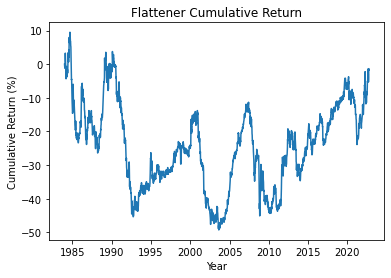

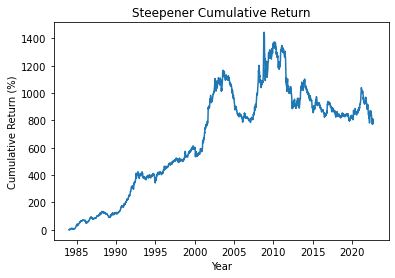

In [10]:
# We start by plotting the cumulative return for both the trading strategies
plt.plot(yc.index, (yc['flattener10']/yc['flattener10'].iloc[0]-1)*100)
plt.title('Flattener Cumulative Return')
plt.xlabel('Year')
plt.ylabel('Cumulative Return (%)')
plt.savefig('flattenercret.png')
plt.show()
plt.plot(yc.index, (yc['steepener10']/yc['steepener10'].iloc[0]-1)*100)
plt.title('Steepener Cumulative Return')
plt.xlabel('Year')
plt.ylabel('Cumulative Return (%)')
plt.savefig('steepenercret.png')
plt.show()


In [5]:
# Although the spread trade is DV01-neutral, there is unhedged convexity. Calculate the
#convexity risk of the spread trade for a 10 basis point change in yields for a constant
#$1mm (in terms of face value) position in the 10 yr Treasury. Plot the convexity risk
#over time.
# Gamma10bp
yc['fgamma10'] = yc.apply(lambda x: (-.5 * x.m2 *(x.m2+1)/(1+x.y2)**2 * x.hr *x.p2 + 0.5 * x.m10*(x.m10+1)/(1+x.y10)**2 * x.p10)*0.001**2*1000000, axis =1)
yc['sgamma10'] = yc.apply(lambda x: (-.5 * x.m2 *(x.m2+1)/(1+x.y2)**2 * x.hr *x.p2 -0.5 * x.m10*(x.m10+1)/(1+x.y10)**2 * x.p10)*0.001**2*1000000, axis =1)


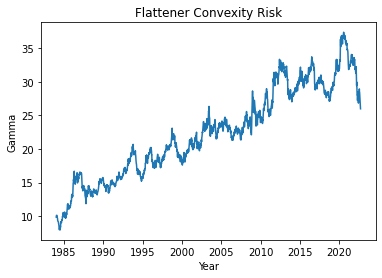

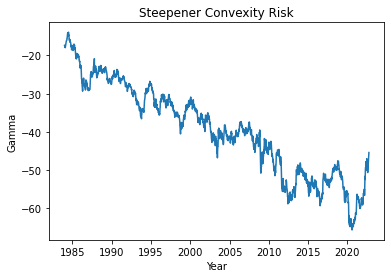

C:\Users\anany\AppData\Local\Temp\ipykernel_15128\1935333672.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc['chg2y'].iloc[0] = 0
C:\Users\anany\AppData\Local\Temp\ipykernel_15128\1935333672.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc['chg10y'].iloc[0] = 0


<Figure size 432x288 with 0 Axes>

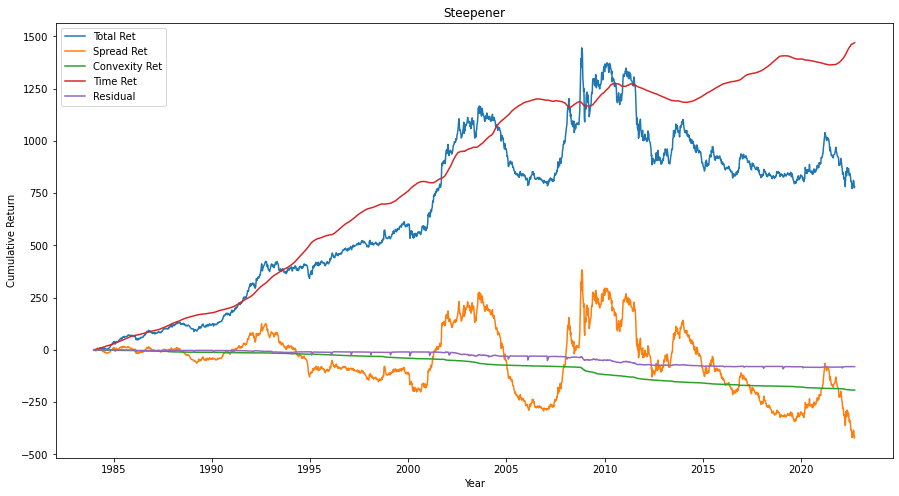

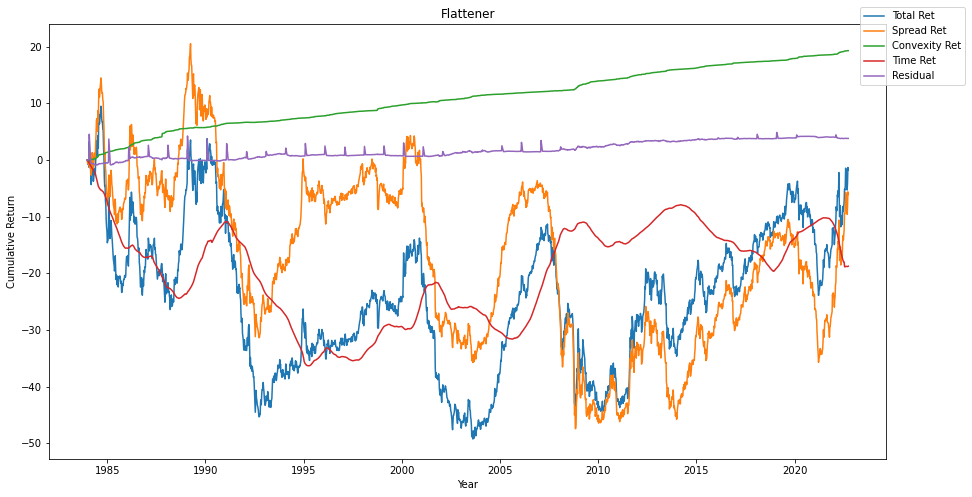

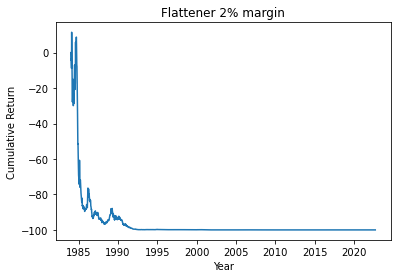

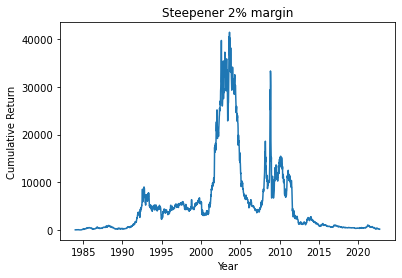

In [6]:
plt.plot(yc.index,yc['fgamma10'])
plt.title('Flattener Convexity Risk')
plt.xlabel('Year')
plt.ylabel('Gamma')
plt.show()
plt.savefig('flattenercr.png')
plt.plot(yc.index,yc['sgamma10'])
plt.title('Steepener Convexity Risk')
plt.xlabel('Year')
plt.ylabel('Gamma')
plt.show()
plt.savefig('steepenercr.png')
#### Return Attribution
#first compute some helpful intermediate quantities
# yield changes
yc['chg2y'] = yc['y2'].diff()
yc['chg2y'].iloc[0] = 0
yc['chg10y'] = yc['y10'].diff()
yc['chg10y'].iloc[0] = 0
# position market values
margin10 = 0.1
margin2 = 0.02
yc['sv10y'] = yc.apply(lambda x: -x.steepener10*w10/margin10, axis =1)
yc['sv2y'] = yc.apply(lambda x: x.steepener10*(1-w10)/margin10, axis =1)
yc['fv10y'] = yc.apply(lambda x: x.flattener10*w10/margin10, axis =1)
yc['fv2y'] = yc.apply(lambda x: -x.flattener10*(1-w10)/margin10, axis =1)
yc['Lsv10y'] = yc['sv10y'].shift()
yc['Lsv2y'] = yc['sv2y'].shift()
yc['Lfv10y'] = yc['fv10y'].shift()
yc['Lfv2y'] = yc['fv2y'].shift()
#cash
yc['scash'] = yc.apply(lambda x: x.steepener10 - (x.sv10y + x.sv2y), axis =1)
yc['fcash'] = yc.apply(lambda x: x.flattener10 - (x.fv10y + x.fv2y), axis =1)
yc['Lscash'] = yc['scash'].shift()
yc['Lfcash'] = yc['fcash'].shift()
yc['sspreadret'] = yc.apply(lambda x: -x.Lsv2y*x.Lm2/(1+x.Ly2)*x.chg2y - x.Lsv10y*x.Lm10/(1+x.Ly10)*x.chg10y, axis =1)
yc['fspreadret'] = yc.apply(lambda x: -x.Lfv2y*x.Lm2/(1+x.Ly2)*x.chg2y - x.Lfv10y*x.Lm10/(1+x.Ly10)*x.chg10y, axis =1)

yc['scxret'] = yc.apply(lambda x: .5*x.Lsv2y*x.Lm2 *(x.Lm2+1)/(1+x.Ly2)**2*x.chg2y**2 + .5*x.Lsv10y*x.Lm10 *(x.Lm10+1)/(1+x.Ly10)**2*x.chg10y**2, axis =1)
yc['fcxret'] = yc.apply(lambda x: .5*x.Lfv2y*x.Lm2 *(x.Lm2+1)/(1+x.Ly2)**2*x.chg2y**2 + .5*x.Lfv10y*x.Lm10 *(x.Lm10+1)/(1+x.Ly10)**2*x.chg10y**2, axis =1)
yc['stime'] = yc.apply(lambda x: x.Lscash*((1+x.Ly7d)**(x.dayslast/365)-1) + x.Lsv2y*(x.p2rd/x.p2 - 1) + x.Lsv10y*(x.p10rd/x.p10 - 1), axis =1)
yc['ftime'] = yc.apply(lambda x: x.Lfcash*((1+x.Ly7d)**(x.dayslast/365)-1) + x.Lfv2y*(x.p2rd/x.p2 - 1) + x.Lfv10y*(x.p10rd/x.p10 - 1), axis =1)
yc = yc.fillna(0)
yc['sspreadret'] = yc['sspreadret'].cumsum()
yc['scxret'] = yc['scxret'].cumsum()
yc['stime'] = yc['stime'].cumsum()
yc['fspreadret'] = yc['fspreadret'].cumsum()
yc['fcxret'] = yc['fcxret'].cumsum()
yc['ftime'] = yc['ftime'].cumsum()
yc['sspreadret'] = (yc['sspreadret'] / yc['steepener10'].iloc[0]) * 100
yc['fspreadret'] = (yc['fspreadret'] / yc['flattener10'].iloc[0]) * 100
yc['scxret'] = (yc['scxret'] / yc['steepener10'].iloc[0]) * 100
yc['fcxret'] = (yc['fcxret'] / yc['flattener10'].iloc[0]) * 100
yc['stime'] = (yc['stime'] / yc['steepener10'].iloc[0]) * 100
yc['ftime'] = (yc['ftime'] / yc['flattener10'].iloc[0]) * 100
yc['stotal'] = (yc['steepener10'] / yc['steepener10'].iloc[0]-1) * 100
yc['ftotal'] = (yc['flattener10'] / yc['flattener10'].iloc[0]-1) * 100
yc['sresidual'] = yc['stotal'] - yc['sspreadret'] - yc['scxret'] - yc['stime']
yc['fresidual'] = yc['ftotal'] - yc['fspreadret'] - yc['fcxret'] - yc['ftime']
# 
#Each week, calculate the duration and convexity for each leg of your trading strategy.
#Given your risk metrics, the changes in yields, and the size of your positions, decompose
#the weekly return into the following components:
#(a) Spread return: the return due to changes in the yield spread using DV01.
#(b) Convexity return: the return due to changes in the yield from convexity.
#(c) Time return: the return due to the passage of time and interest on the cash position.
#d) Residual: the difference between the total return and the sum of the spread return,
#convexity return, and time return.
#Create a plot of the cumulative total return, spread return, convexity return, time
#return, and the residual. How much did each component contribute to the total return?
#Plot Steepener
fig = plt.figure(figsize = [15,8])
plt.plot(yc.index,yc['stotal'],label = "Total Ret" )
plt.plot(yc.index,yc['sspreadret'],label = "Spread Ret" )
plt.plot(yc.index,yc['scxret'],label = "Convexity Ret")
plt.plot(yc.index,yc['stime'],label = "Time Ret")
plt.plot(yc.index,yc['sresidual'],label = "Residual")
plt.legend()
plt.title('Steepener')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.savefig('steepener.png')
plt.show()
#Plot Flattener
fig = plt.figure(figsize = [15,8])
plt.plot(yc.index,yc['ftotal'],label = "Total Ret" )
8
plt.plot(yc.index,yc['fspreadret'],label = "Spread Ret" )
plt.plot(yc.index,yc['fcxret'],label = "Convexity Ret")
plt.plot(yc.index,yc['ftime'],label = "Time Ret")
plt.plot(yc.index,yc['fresidual'],label = "Residual")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Flattener')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.savefig('flattener.png')
plt.show()
# How does a 2% margin requirement impact the cumulative return of your trading
#strategy? Plot the cumulative total return of the 2% margin requirement compared to
#the 10% margin requirement.
#Plot Flattener 2% margin
plt.plot(yc.index,(yc['flattener2']/yc['flattener2'].iloc[0]-1)*100)
plt.title("Flattener 2% margin")
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.savefig('flattener2pct.png')
plt.show()
#Plot Steepener 2% margin
plt.plot(yc.index,(yc['steepener2']/yc['steepener2'].iloc[0]-1)*100)
plt.title("Steepener 2% margin")
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.savefig('steepener2pct.png')
plt.show()

In [8]:
yc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2022 entries, 1983-12-30 to 2022-09-23
Freq: W-FRI
Data columns (total 74 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2022 non-null   datetime64[ns]
 1   BETA0        2022 non-null   float64       
 2   BETA1        2022 non-null   float64       
 3   BETA2        2022 non-null   float64       
 4   BETA3        2022 non-null   float64       
 5   TAU1         2022 non-null   float64       
 6   TAU2         2022 non-null   float64       
 7   dayslast     2022 non-null   float64       
 8   dayslast1    2022 non-null   float64       
 9   daysnext     2022 non-null   float64       
 10  noleap_date  2022 non-null   datetime64[ns]
 11  m2           2022 non-null   float64       
 12  m10          2022 non-null   float64       
 13  m2rd         2022 non-null   float64       
 14  m10rd        2022 non-null   float64       
 15  Lm2          2022 non-nul